# Statistical Region Merging

Statistical region merging is local image segmentation technique that groups regions of voxels based on a similarity criteria related to the region's mean gray level.

## Import packages

In [2]:
import dpm_tools as dpm
import numpy as np
import matplotlib.pyplot as plt

[11:45:45] ERROR    PARDISO solver not installed, run `pip install pypardiso`. Otherwise,          ]8;id=444106;file://C:\Users\bcc2459\AppData\Roaming\Python\Python312\site-packages\openpnm\utils\_workspace.py\_workspace.py]8;;\:]8;id=993725;file://C:\Users\bcc2459\AppData\Roaming\Python\Python312\site-packages\openpnm\utils\_workspace.py#56\56]8;;\
                    simulations will be slow. Apple M chips not supported.                                         

## Demonstration Image

Here, we will demonstrated the ``seeded_region_growing()`` function using a 3D $\mu$-CT image of an [oil blob trapped in a Ketton limestone](https://doi.org/10.17612/P7D95F).

Text(0.5, 0, 'Grayscale value')

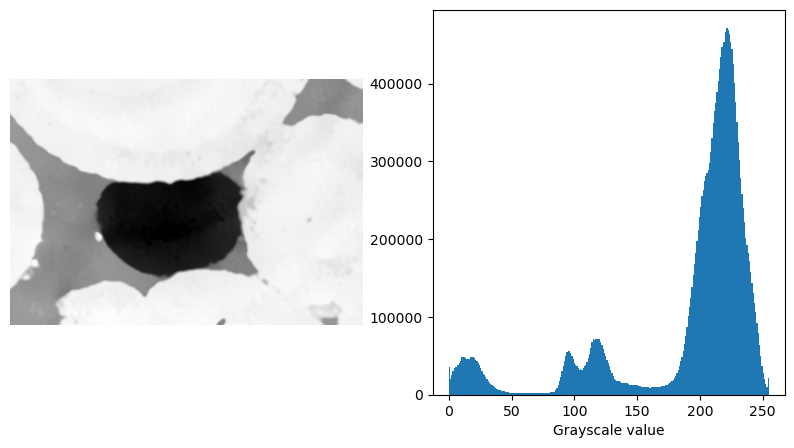

In [3]:
filtered_ketton = "../../_static/Ketton_rock_trapped_oil_Filtered_SSb.raw"

ketton_img = np.fromfile(filtered_ketton, dtype=np.uint16).reshape((225, 255, 365))

# Requantize ketton_img
ketton_img = (ketton_img - np.quantile(ketton_img, 0.001)) / (np.quantile(ketton_img, 0.999) - np.quantile(ketton_img, 0.001))
ketton_img[ketton_img < 0] = 0
ketton_img[ketton_img > 1] = 1

# Convert to uint8
ketton_img = (ketton_img * 255).astype(np.uint8)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.imshow(ketton_img[125], cmap="Greys_r")
ax1.axis(False)

ax2.hist(ketton_img.flatten(), bins=256)
ax2.set_xlabel("Grayscale value")

## Statistical region merging (SRM)

In statistical region merging, you request a number of phases Q but you will get something close to it in the iterative
statistical region merging process. This can be viewed as a type of gray level filtering, of course, and Q decides how aggressive do
you want it to be (the smaller the Q, more merging happens).

The fact that the result does not precisely have Q regions in the end is actually a good thing as many times we do not know how many phases we have in the image and should not prescribe it.

This SRM image is a filtered image where the histogram should show where and how to threshold to get the result you need. 

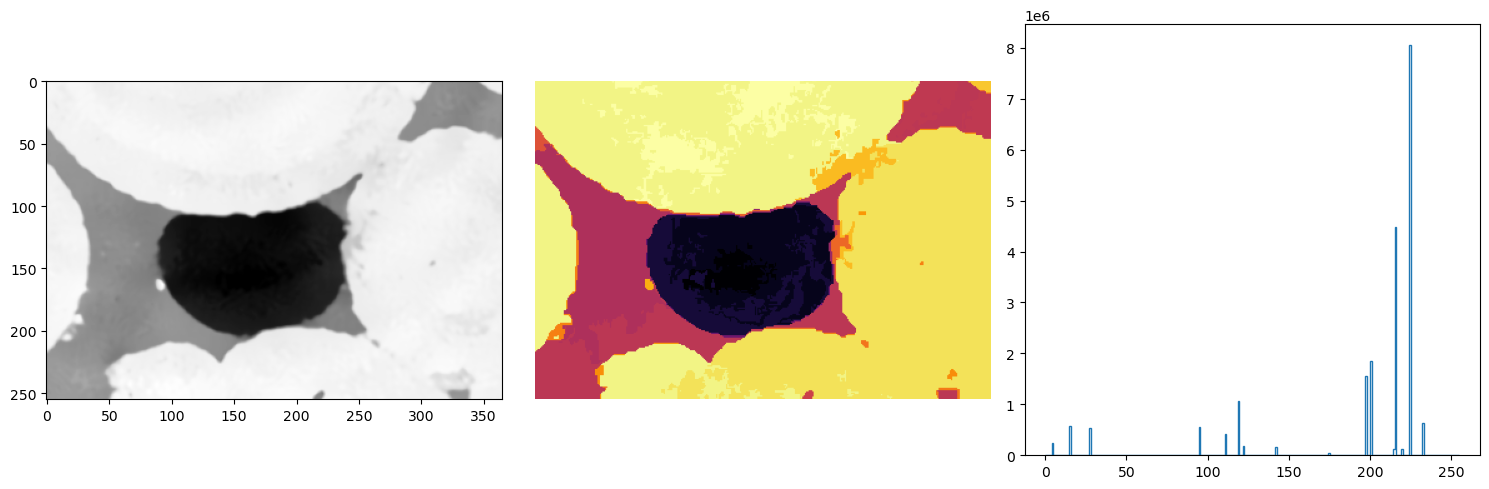

In [11]:
ketton_srm = dpm.segmentation.statistical_region_merging(ketton_img, Q=16)

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(ketton_img[125], cmap="Greys_r")
ax[1].axis(False)

ax[1].imshow(ketton_srm[125], cmap="inferno")
ax[1].axis(False)

ax[2].hist(ketton_srm.flatten(), bins=256, range=(0, 255), histtype="step")
plt.tight_layout()

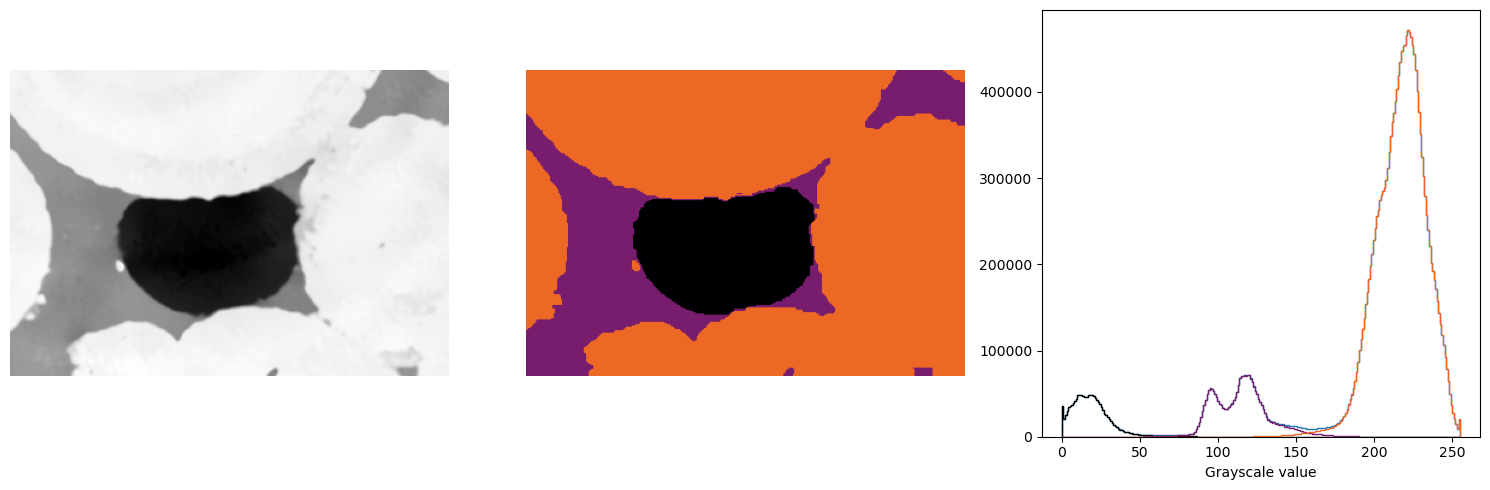

In [17]:
# Do some thresholding on the SRM result
threshold_1 = 75
threshold_2 = 150

phase1 = (ketton_srm < threshold_1)*0
phase2 = ((ketton_srm >= threshold_1) & (ketton_srm <= threshold_2)).astype(np.uint8) * 1
phase3 = (ketton_srm > threshold_2).astype(np.uint8) * 2

segmented = phase1 + phase2 + phase3

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(ketton_img[125], cmap="Greys_r")
ax[0].axis(False)

ax[1].imshow(segmented[125], cmap="inferno", vmin=0, vmax=3)
ax[1].axis(False)

ax[2].hist(ketton_img.flatten(), bins=256, range=(0, 255), histtype="step")
ax[2].hist(ketton_img[segmented == 0].flatten(), bins=256, range=(0, 255), histtype="step", color="k")
ax[2].hist(ketton_img[segmented == 1].flatten(), bins=256, range=(0, 255), histtype="step", color="#781c6d")
ax[2].hist(ketton_img[segmented == 2].flatten(), bins=256, range=(0, 255), histtype="step", color="#ed6825")
ax[2].set_xlabel("Grayscale value")
plt.tight_layout()